# Hollywood Movies: Convert .mov to .tiff files

Gets random list of high-res .mov source files and puts them into a test and a training sequence.
  - saves image stacks as "../data/processed/movies_test.tiff" and "../data/processed/movies_train.tiff"
  - for reproducibility, the meta data for each scene (source file name, start frame, frame x/y-pos, and first/last index in the .tiff stacks) are saveed in "..data/processed/test_meta.json" and "..data/processed/training_meta.json"

## TODO
- check if and ensure in code that there was no resample for low-res version!
 - make this programmatic: 
  - set do_resize=True only if frame_shape > expected_original; else set to False and set frame_shape_res = None
 - check against movie files on server


## Setup

In [1]:
# Import libraries
import numpy as np
import os
import imageio
from skimage.transform import resize
import matplotlib.pyplot as plt
import json
from datetime import datetime

In [9]:
# Set parameters

# General hollymov version info
version_num = 3 # version number
histogram_equ = False # this version will NOT use histogram equalized frames 

# Set desired frame size (pixels, width by height)
frame_shape = [424, 264] # [212, 132]# shape of cropped output frames (may be crops from resampled frame, but not larger)

# Set desired stimulus sequence parameters (may differ in final stimulus file)
total_dur = 30 # desired total movie sequence duration (min)
scene_dur = 5 # scene duration (s)
fps = 30 # framerate of original and output movies (frames per second) -> 150 fpscene
percent_train = 0.8 # train-test split: 80% training
percent_test = 0.2 # train-test split: 20% test

Desired output frame shape larger than original input frame shape. Will resize.


In [ ]:
# Check desired ouput against original input frame shape
frame_shape_orig_expected = [448, 252] # expected original input movie frame shape
if (frame_shape[0] > frame_shape_orig_expected[0]) or (frame_shape[1] > frame_shape_orig_expected[1]):
    print('Desired output frame shape larger than original input frame shape. Will resize.')
    do_resize = True # resize source images or not
    frame_shape_res = [512, 288] # 2*[256, 144] # shape of resized frame, used only if resizing frames
else:
    do_resize = False # resize source images or not
    frame_shape_res = [] #[256, 144]# shape of resized frame, used only if resizing frames
# pix_per_deg = 4 # pixels per degree: 4 in Tuebingen retina experiments; 2 in Houston

In [3]:
# Make processed data directory unless it already exists
try:
    os.makedirs("../data/processed/")
except FileExistsError:
    print('Directory ../data/processed/ already exists!') # directory already exists
    pass

Directory ../data/processed/ already exists!


## Calculate required scene numbers, durations, and partitions

In [4]:
total_dur_s = total_dur * 60
total_n_scenes = int(total_dur_s / scene_dur) # desired total dur (min) * 60 s / 5 s per scene
n_unique_train_scenes = int(total_n_scenes * percent_train)
n_repeated_test_scenes = int(total_n_scenes * percent_test)

print("Total dur (s):", total_dur_s)
print("Total n scenes:", total_n_scenes)
print("N unique training scenes:", n_unique_train_scenes)
print("N repeated test scenes:", n_repeated_test_scenes)

Total dur (s): 1800
Total n scenes: 360
N unique training scenes: 288
N repeated test scenes: 72


In [5]:
# Choose desired number of unique scenes for test sequence based on the above results
n_unique_test_scenes = 8
n_test_scene_repeats = int(n_repeated_test_scenes / n_unique_test_scenes)
n_total_train_test_scenes = n_unique_train_scenes + n_unique_test_scenes

print("N unique test scenes:", n_unique_test_scenes)
print("N test sequence repeats:", n_test_scene_repeats)
print("N total training + test scenes:", n_total_train_test_scenes)

N unique test scenes: 8
N test sequence repeats: 9
N total training + test scenes: 296


In [6]:
# Split training seq into appropriate n parts based on n test repeats
n_train_parts = n_test_scene_repeats - 1
n_scenes_per_train_part = int(n_unique_train_scenes / n_train_parts)

print("N training parts:", n_train_parts)
print("N scenes per training part:", n_scenes_per_train_part)

N training parts: 8
N scenes per training part: 36


In [7]:
# Get some more duration numbers
total_dur_train_seq = n_unique_train_scenes * scene_dur # seconds
dur_per_train_part = n_scenes_per_train_part * scene_dur # seconds

total_dur_test_seq = n_unique_test_scenes * n_test_scene_repeats * scene_dur # seconds
dur_per_test_seq = n_unique_test_scenes * scene_dur # seconds

print("Total dur training sequences:\t", total_dur_train_seq, "s =", total_dur_train_seq / 60, "min")
print("Duration per training part:\t", dur_per_train_part, "s =", dur_per_train_part / 60, "min")
print("Total dur test sequences:\t", total_dur_test_seq, "s =", total_dur_test_seq / 60, "min")
print("Duration per test sequence:\t", dur_per_test_seq, "s =", dur_per_test_seq / 60, "min")


Total dur training sequences:	 1440 s = 24.0 min
Duration per training part:	 180 s = 3.0 min
Total dur test sequences:	 360 s = 6.0 min
Duration per test sequence:	 40 s = 0.6666666666666666 min


## Get list of available source files

In [8]:
# Get film folders
dir_name = '../data/original/Holly - HighRes'
film_folders = [folder for folder in os.listdir(dir_name) if not folder.startswith('Icon')]
print('Following films found:')
for i in film_folders:
    print(i)

FileNotFoundError: [Errno 2] No such file or directory: '../data/original/Holly - HighRes'

In [ ]:
# Get individual film scenes into a list
file_list = []
for iFilm in film_folders:
    film_scenes = [dir_name + '/' + iFilm + '/' + scene for scene in os.listdir(dir_name + '/' + iFilm) if not scene.startswith('Icon')]
    file_list.extend(film_scenes)

# Print random selection of scene names
print('%i scenes found. \nRandom subselection below:' % len(file_list))
print(np.random.choice(file_list, size=10, replace=False))

## Randomly select test and training scenes

In [ ]:
# Fix seed
np.random.seed(123)

# Scene list
print('Selecting %i random scenes for test and training.' % n_total_train_test_scenes)
scene_sel = np.random.choice(file_list, size=n_total_train_test_scenes, replace=False)
# print(scene_sel)

# Test scenes
print('Selecting %i scenes for test.' % n_unique_test_scenes)
test_sel = scene_sel[0:n_unique_test_scenes]
print(test_sel)

# Training scenes
print('Selecting %i scenes for training. Subselection below.' % n_unique_train_scenes)
train_sel = scene_sel[n_unique_test_scenes::]
print(train_sel[0:10])

## Process test sequence

In [ ]:
# Process test sequence
# NOTE: Be aware of difference in shape formats: e.g. frame_shape = [x,y] <> imageio: [y,x]
print('Processing test sequence:')
start_time = datetime.now() # time code execution

if do_resize:
    print('Resizing images to %ix%i and cropping to %ix%i.\n' % 
          (frame_shape_res[0], frame_shape_res[1], frame_shape[0], frame_shape[1]))

# Initialize scene and sequence arrays (transposed shape conforms to imageio format)
scene = np.zeros((scene_dur * fps, frame_shape[1], frame_shape[0]), dtype=np.uint8)
test_seq = np.zeros((scene_dur*fps*n_unique_test_scenes, frame_shape[1], frame_shape[0]), 
                    dtype=np.uint8)

# initialize test meta data
test_meta = dict(general={}, scene=[])

first, last = 0, scene_dur*fps-1 # initialize first and last array index for meta data

np.random.seed(234) # fix seed

# Go through scenes
for file_idx, file_name in enumerate(test_sel):
    print(file_idx+1,'/', n_unique_test_scenes, ':', file_name)
    
    # Read file
    decoder = imageio.get_reader(file_name,  'ffmpeg')
    scene_meta = decoder.get_meta_data()    
    
    # Pick random start frame to extract 5 s scene from 1 min file    
    start_frame = np.random.randint(scene_meta['nframes'] - scene_dur * fps) # constrain to max len
    
    # Process image, resized or non-resized
    if do_resize:
        # Pick x and y location
        # if desired x/y-size is the same as max actual x/y-size, take whole x/y size,
        # else get random x/y, constrained to frame size
        if scene.shape[2] - frame_shape_res[0] == 0: 
            x = np.random.randint(frame_shape_res[0]+1 - scene.shape[2]) # take whole x-size
        else:
            x = np.random.randint(frame_shape_res[0] - scene.shape[2])

        if scene.shape[1] - frame_shape_res[1] == 0:
            y = np.random.randint(frame_shape_res[1]+1 - scene.shape[1]) # take whole y-size
        else:
            y = np.random.randint(frame_shape_res[1] - scene.shape[1])    

        # Get selected scene frames in array
        for i,frame in enumerate(range(start_frame, start_frame + scene_dur*fps)):
            img = (decoder.get_data(frame).mean(axis=-1).astype(np.uint8))
            
            # Resize image w skimage.transform.resize            
            img_res = resize(img, (frame_shape_res[1], frame_shape_res[0]), anti_aliasing=True,
                             mode='reflect', preserve_range=True).astype(np.uint8)

            # Crop image
            img_crop = img_res[y:y+frame_shape[1], x:x+frame_shape[0]]
            
            # Store image
            scene[i,:,:] = img_crop
                        
    elif not do_resize:
        # Pick x and y location
        # if desired x/y-size is the same as max actual x/y-size, take whole x/y size,
        # else get random x/y, constrained to frame size
        if scene_meta['size'][0] - frame_shape[0] == 0: 
            x = np.random.randint(scene_meta['size'][0]+1 - frame_shape[0]) # take whole x-size
        else:
            x = np.random.randint(scene_meta['size'][0] - frame_shape[0])

        if scene_meta['size'][1] - frame_shape[1] == 0:
            y = np.random.randint(frame_shape_res[1]+1 - scene.shape[1]) # take whole y-size
        else:
            y = np.random.randint(scene_meta['size'][1] - frame_shape[1])    

        # Get selected scene frames in array
        for i,frame in enumerate(range(start_frame, start_frame + scene_dur*fps)):
            scene[i,:,:] = (decoder.get_data(frame)[y:y+frame_shape[1], x:x+frame_shape[0], :].
                            mean(axis=-1).astype(np.uint8))

    # Store scene in scene sequence
    test_seq[first:last+1,:,:] = scene

    # Store meta data
    test_meta['scene'].append({
        'scene_idx': file_idx, # scene number
        'file_name_orig': file_name, # source file name
        'start_frame': start_frame, # start frame from original source scene
        'start_x': x, # start x pixel from source
        'start_y': y, # start y pixel from source
        'first': first, # start index in seq
        'last': last, # stop index in seq
        })
    
    # Update frame indices for next scene
    first += scene_dur*fps
    last += scene_dur*fps
    
# Insert general meta data    
test_meta['general'] = {
    'version_num': version_num, # version number of the hollywood movie
    'test_v_train': 'test', # whether this meta data is for the test or training sequence (also in file name)
    'histogram_equ': histogram_equ, # whether there will be histogram equalization or not
    'frame_shape_orig': list(scene_meta['size']), # original file frame shape
    'do_resize': do_resize, # whether or not original file frame shape was resampled
    'frame_shape_resampled': frame_shape_res, # resampled frame shape
    'frame_shape': frame_shape, # output frame shape
    'total_dur_min': total_dur, # expected total duration (min) of stimulus (training + test sequence) 
    'scene_dur_sec': scene_dur, # scene duration (seconds)
    'fps': fps, # frames per second
    'n_unique_scenes_test': n_unique_test_scenes, # number of uniques test scenes
    'n_scene_repeats_test': n_test_scene_repeats, # expected number of repeats per test scene
    'percent_train': percent_train, # expected percentage training sequences
    'percent_test': percent_test, # expected percentage test sequences
    }
# NOTE: total_dur_min, n_scene_repeats_test, percent_train, percent_test: 
# - Expected values may differ depending on final experimental stimulus presentation file!

print('\nDuration: {}'.format(datetime.now() - start_time))    

In [ ]:
test_meta

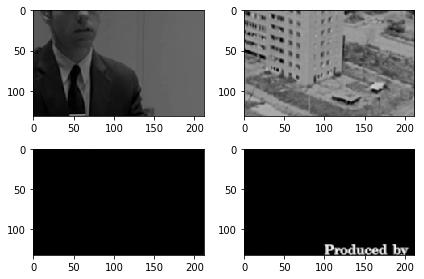

In [13]:
# Show n random image frames
n = 4
rand_ind = np.random.choice(test_seq.shape[0], n, replace=False)
for i_frame in range(n):
    plt.subplot(int(np.sqrt(n)), int(np.sqrt(n)), i_frame+1)
    plt.imshow(test_seq[rand_ind[i_frame], :,:], vmin=0, vmax=255, cmap='gray')
    plt.grid(False)
plt.tight_layout()
plt.show()

In [14]:
# Save sequence
fname = '../data/processed/hmovTest.tiff'
print('Saving %s' % fname)

# Check if file size > 4GB: if so, save as bigtiff, else save as standard tiff
if test_seq.nbytes > 4e9:
    print('File size > 4GB. Saving as bigtiff.')
    imageio.mimwrite(fname, test_seq, 'TIFF', bigtiff=True)
else:
    imageio.mimwrite(fname, test_seq, 'TIFF')

# Save metadata
fname = '../data/processed/hmovTestMeta.json'
print('Saving %s' % fname)
with open(fname, 'w') as f:
    json.dump(test_meta, f, indent=4)    

Saving ../data/processed/hmovTest.tiff
Saving ../data/processed/hmovTestMeta.json


/Users/Yannik/anaconda3/lib/python3.6/site-packages/imageio/plugins/_tifffile.py:7285: UserWarning: module 'imageio.plugins._tifffile' has no attribute 'decode_packbits'
  Functionality might be degraded or be slow.

  warnings.warn("%s%s" % (e, warn))
/Users/Yannik/anaconda3/lib/python3.6/site-packages/imageio/plugins/_tifffile.py:7285: UserWarning: module 'imageio.plugins._tifffile' has no attribute 'decode_lzw'
  Functionality might be degraded or be slow.

  warnings.warn("%s%s" % (e, warn))
/Users/Yannik/anaconda3/lib/python3.6/site-packages/imageio/plugins/_tifffile.py:7285: UserWarning: module 'imageio.plugins._tifffile' has no attribute 'unpack_ints'
  Functionality might be degraded or be slow.

  warnings.warn("%s%s" % (e, warn))
/Users/Yannik/anaconda3/lib/python3.6/site-packages/imageio/plugins/_tifffile.py:7285: UserWarning: module 'imageio.plugins._tifffile' has no attribute 'reverse_bitorder'
  Functionality might be degraded or be slow.

  warnings.warn("%s%s" % (e, war

In [15]:
# Check meta data file
with open(fname, 'r') as f:
    data = json.load(f)
data

{'general': {'frame_shape_orig': [448, 252],
  'do_resize': True,
  'frame_shape_resampled': [512, 288],
  'frame_shape': [212, 132],
  'total_dur_min': 30,
  'scene_dur_sec': 5,
  'fps': 30,
  'n_unique_test_scenes': 8,
  'n_test_scene_repeats': 9,
  'percent_train': 0.8,
  'percent_test': 0.2},
 'scene': [{'scene_idx': 0,
   'file_name_orig': '../data/original/Holly - HighRes/MadMax/MadMax_060.mov',
   'start_frame': 456,
   'start_x': 185,
   'start_y': 95,
   'first': 0,
   'last': 150},
  {'scene_idx': 1,
   'file_name_orig': '../data/original/Holly - HighRes/Starwars/starwars_021.mov',
   'start_frame': 1185,
   'start_x': 3,
   'start_y': 54,
   'first': 150,
   'last': 300},
  {'scene_idx': 2,
   'file_name_orig': '../data/original/Holly - HighRes/Starwars/starwars_098.mov',
   'start_frame': 1011,
   'start_x': 240,
   'start_y': 63,
   'first': 300,
   'last': 450},
  {'scene_idx': 3,
   'file_name_orig': '../data/original/Holly - HighRes/Matrix/matrix_020.mov',
   'start_fra

In [16]:
# Free up space
del test_seq
del test_meta

## Process training sequence

In [17]:
# Process training sequence
# NOTE: Be aware of difference in shape formats: e.g. frame_shape = [x,y] <> imageio: [y,x]
print('Processing training sequence:')
start_time = datetime.now() # time code execution

if do_resize:
    print('Resizing images to %ix%i and cropping to %ix%i.\n' % 
          (frame_shape_res[0], frame_shape_res[1], frame_shape[0], frame_shape[1]))

# Initialize scene and sequence arrays (transposed shape conforms to imageio format)
scene = np.zeros((scene_dur * fps, frame_shape[1], frame_shape[0]), dtype=np.uint8)
train_seq = np.zeros((scene_dur*fps*n_unique_train_scenes, frame_shape[1], frame_shape[0]), 
                    dtype=np.uint8)

# initialize training meta data
train_meta = dict(general={}, scene=[])

first, last = 0, scene_dur*fps-1 # initialize first and last array index for meta data

np.random.seed(345) # fix seed


# Go through scenes
for file_idx, file_name in enumerate(train_sel):
    print(file_idx+1,'/', n_unique_train_scenes, ':', file_name)
    
    # Read file
    decoder = imageio.get_reader(file_name,  'ffmpeg')
    scene_meta = decoder.get_meta_data()
    
    # Pick random start frame to extract 5 s scene from 1 min file    
    start_frame = np.random.randint(scene_meta['nframes'] - scene_dur * fps) # constrain to max len
    
    # Process image, resized or non-resized
    if do_resize:
        # Pick x and y location
        # if desired x/y-size is the same as max actual x/y-size, take whole x/y size,
        # else get random x/y, constrained to frame size
        if scene.shape[2] - frame_shape_res[0] == 0: 
            x = 0 # take whole x-size
        else:
            x = np.random.randint(frame_shape_res[0] - scene.shape[2])

        if scene.shape[1] - frame_shape_res[1] == 0:
            y = 0 # take whole y-size
        else:
            y = np.random.randint(frame_shape_res[1] - scene.shape[1])    

        # Get selected scene frames in array
        for i,frame in enumerate(range(start_frame, start_frame + scene_dur*fps)):
            img = (decoder.get_data(frame).mean(axis=-1).astype(np.uint8))
            
            # Resize image w skimage.transform.resize            
            img_res = resize(img, (frame_shape_res[1], frame_shape_res[0]), anti_aliasing=True,
                             mode='reflect', preserve_range=True).astype(np.uint8)

            # Crop image
            img_crop = img_res[y:y+frame_shape[1], x:x+frame_shape[0]]
            
            # Store image
            scene[i,:,:] = img_crop
                        
    elif not do_resize:
        # Pick x and y location
        # if desired x/y-size is the same as max actual x/y-size, take whole x/y size,
        # else get random x/y, constrained to frame size
        if scene_meta['size'][0] - frame_shape[0] == 0: 
            x = 0 # take whole x-size
        else:
            x = np.random.randint(scene_meta['size'][0] - frame_shape[0])

        if scene_meta['size'][1] - frame_shape[1] == 0:
            y = 0 # take whole y-size
        else:
            y = np.random.randint(scene_meta['size'][1] - frame_shape[1])    

        # Get selected scene frames in array
        for i,frame in enumerate(range(start_frame, start_frame + scene_dur*fps)):
            scene[i,:,:] = (decoder.get_data(frame)[y:y+frame_shape[1], x:x+frame_shape[0], :].
                            mean(axis=-1).astype(np.uint8))

    # Store scene in scene sequence
    train_seq[first:last+1,:,:] = scene

    # Store scene meta data
    train_meta['scene'].append({
        'scene_idx': file_idx,
        'file_name_orig': file_name, # source file name
        'start_frame': start_frame, # start frame from original source scene
        'start_x': x, # start x pixel from source
        'start_y': y, # start y pixel from source
        'first': first, # start index in seq
        'last': last, # stop index in seq
        })
    
    # Update frame indices for next scene
    first += scene_dur*fps
    last += scene_dur*fps

    
# Insert general meta data        
train_meta['general'] = {
    'version_num': version_num, # version number of the hollywood movie
    'test_v_train': 'train', # whether this meta data is for the test or training sequence (also in file name)
    'histogram_equ': histogram_equ, # whether there will be histogram equalization or not
    'frame_shape_orig': list(scene_meta['size']), # original file frame shape
    'do_resize': do_resize, # whether or not original file frame shape was resampled
    'frame_shape_resampled': frame_shape_res, # resampled frame shape
    'frame_shape': frame_shape, # output frame shape
    'total_dur_min': total_dur, # total duration of stimulus (training + test sequence) (minutes)
    'scene_dur_sec': scene_dur, # scene duration (seconds)
    'fps': fps, # frames per second
    'n_unique_scenes_train': n_unique_train_scenes, # number of uniques training scenes
    'n_parts_train': n_train_parts, # expected number of parts that training sequence is split into
    'n_scenes_per_part_train': n_scenes_per_train_part, # number of scenes per training part
    'percent_train': percent_train, # expected percentage training sequences
    'percent_test': percent_test, # expected percentage test sequences
    }
# NOTE: total_dur_min, n_parts_train, percent_train, percent_test: 
# - Expected values may differ depending on final experimental stimulus presentation file!
    
print('\nDuration: {}'.format(datetime.now() - start_time))    

Processing training sequence:
Resizing images to 512x288 and cropping to 212x132.

1 / 288 : ../data/original/Holly - HighRes/MadMax/MadMax_076.mov
2 / 288 : ../data/original/Holly - HighRes/Matrix Reloaded/matrixrl_022.mov
3 / 288 : ../data/original/Holly - HighRes/Matrix/matrix_068.mov
4 / 288 : ../data/original/Holly - HighRes/Starwars/starwars_099.mov
5 / 288 : ../data/original/Holly - HighRes/Matrix/matrix_009.mov
6 / 288 : ../data/original/Holly - HighRes/POWAQQATSI/poqatsi_005.mov
7 / 288 : ../data/original/Holly - HighRes/Matrix Revolutions/matrixrv_025.mov
8 / 288 : ../data/original/Holly - HighRes/Starwars/starwars_125.mov
9 / 288 : ../data/original/Holly - HighRes/Starwars/starwars_135.mov
10 / 288 : ../data/original/Holly - HighRes/POWAQQATSI/poqatsi_048.mov
11 / 288 : ../data/original/Holly - HighRes/MadMax/MadMax_100.mov
12 / 288 : ../data/original/Holly - HighRes/Starwars/starwars_022.mov
13 / 288 : ../data/original/Holly - HighRes/KOYAANISQATSI/koyqatsi_079.mov
14 / 288

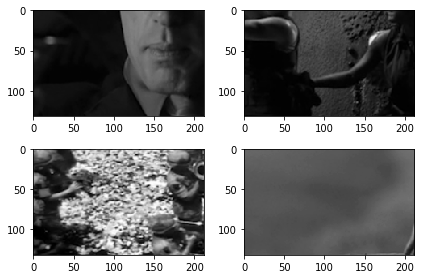

In [18]:
# Show n random image frames
n = 4
rand_ind = np.random.choice(train_seq.shape[0], n, replace=False)
for i_frame in range(n):
    plt.subplot(int(np.sqrt(n)), int(np.sqrt(n)), i_frame+1)
    plt.imshow(train_seq[rand_ind[i_frame], :,:], vmin=0, vmax=255, cmap='gray')
    plt.grid(False)
plt.tight_layout()
plt.show()

In [19]:
# Save sequence
fname = '../data/processed/hmovTrain.tiff'
print('Saving %s' % fname)

# Check if file size > 4GB: if so, save as bigtiff, else save as standard tiff
if train_seq.nbytes > 4e9:
    print('File size > 4GB. Saving as bigtiff.')
    imageio.mimwrite(fname, train_seq, 'TIFF', bigtiff=True)
else:
    imageio.mimwrite(fname, train_seq, 'TIFF')

# Save metadata
fname = '../data/processed/hmovTrainMeta.json'
print('Saving %s' % fname)
with open(fname, 'w') as f:
    json.dump(train_meta, f, indent=4) 

Saving ../data/processed/hmovTrain.tiff
Saving ../data/processed/hmovTrainMeta.json


In [20]:
# Free up space
del train_seq
del train_meta